# Portfolio Optimization With Unconstraint¶


## Introduction

A tutorial for a portfolio optimization problem for n assets:

$$
\min_{w\in\{0,1\}^n}\ qw^T \Sigma w - R^T w
$$

In [6]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Define problem instance

生成数据，定义问题

$$
n \to num\_assets
\\
R \to R
\\
\Sigma \to Sigma
$$

In [7]:
# set number of assets (= number of qubits)
num_assets = 4
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2021, 11, 17),
    end=datetime.datetime(2022, 11, 17),
    seed=seed,
)
data.run()

R = data.get_period_return_mean_vector()
Sigma = data.get_period_return_covariance_matrix()

查看数据

公式到代码的替换：
$$
q \to q
\\
B \to budget
$$

In [8]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=R, covariances=Sigma, risk_factor=q, budget=budget
)

unconstraint_quadratic_problem = portfolio.to_quadratic_program()
unconstraint_quadratic_problem.remove_linear_constraint(0)
unconstraint_quadratic_problem

<QuadraticProgram: minimize 3.827312812733226e-05*x_0^2 + 2.589054469082886e-0..., 4 variables, 0 constraints, 'Portfolio optimization'>

定义一个方法用于打印结果

In [4]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## NumPyMinimumEigensolver (as a classical reference)¶


我们在这里首先考虑经典的解决方案。

我们使用经典的NumPyMinimumEigensolver算法，来求解上述二次约束问题。

In [9]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(unconstraint_quadratic_problem)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0022		1.0000


## Solution using SamplingVQE

使用VQE方法进行求解问题。

我们现在可以使用采样变分量子特征求解器（SamplingVQE）来解决该问题。我们将指定要使用的优化器和变分形式。

In [10]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234

## 选择优化器，封装在qiskit.algorithms.optimizers中。
cobyla = COBYLA()
cobyla.set_options(maxiter=500)

ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")

vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(unconstraint_quadratic_problem)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.0022		0.6602
 [1 0 1 1]	-0.0018		0.1660
 [0 0 1 1]	-0.0013		0.0967
 [1 1 0 0]	0.0021		0.0312
 [0 0 1 0]	-0.0017		0.0146
 [1 1 1 1]	0.0008		0.0117
 [0 1 1 0]	0.0009		0.0049
 [0 0 0 1]	0.0004		0.0049
 [0 0 0 0]	0.0000		0.0049
 [1 1 1 0]	0.0004		0.0029
 [1 0 0 0]	-0.0005		0.0010
 [1 1 0 1]	0.0025		0.0010


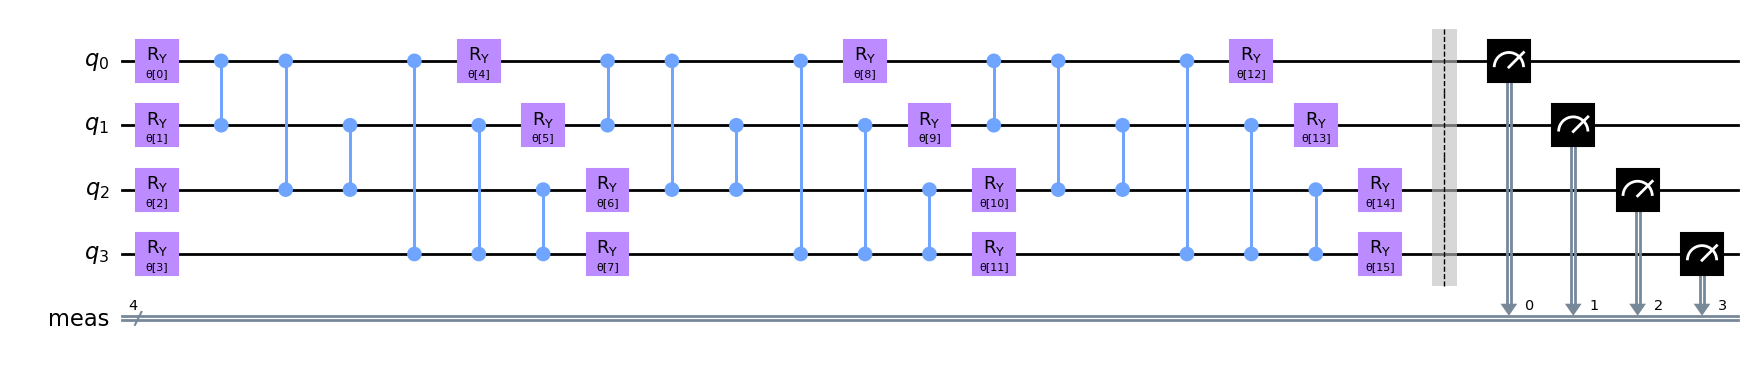

In [11]:
ry.decompose().draw("mpl")

## Solution using QAOA

我们还在这里展示了使用量子近似优化算法（QAOA）的结果。这是另一种变分算法，它使用根据问题创建的内部变分形式。

In [12]:
algorithm_globals.random_seed = 1234

## 选择优化器
cobyla = COBYLA()
cobyla.set_options(maxiter=250)

## 构建QAOA电路，其中p为3.
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(unconstraint_quadratic_problem)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 0 0 1]	0.0004		0.0762
 [1 1 1 1]	0.0008		0.0742
 [0 1 0 0]	0.0025		0.0713
 [0 0 1 1]	-0.0013		0.0674
 [0 0 1 0]	-0.0017		0.0674
 [1 1 0 1]	0.0025		0.0625
 [1 0 0 1]	-0.0001		0.0615
 [1 1 0 0]	0.0021		0.0615
 [0 1 1 0]	0.0009		0.0605
 [0 1 0 1]	0.0030		0.0596
 [1 0 0 0]	-0.0005		0.0576
 [1 1 1 0]	0.0004		0.0576
 [1 0 1 1]	-0.0018		0.0576
 [0 0 0 0]	0.0000		0.0557
 [1 0 1 0]	-0.0022		0.0547
 [0 1 1 1]	0.0013		0.0547


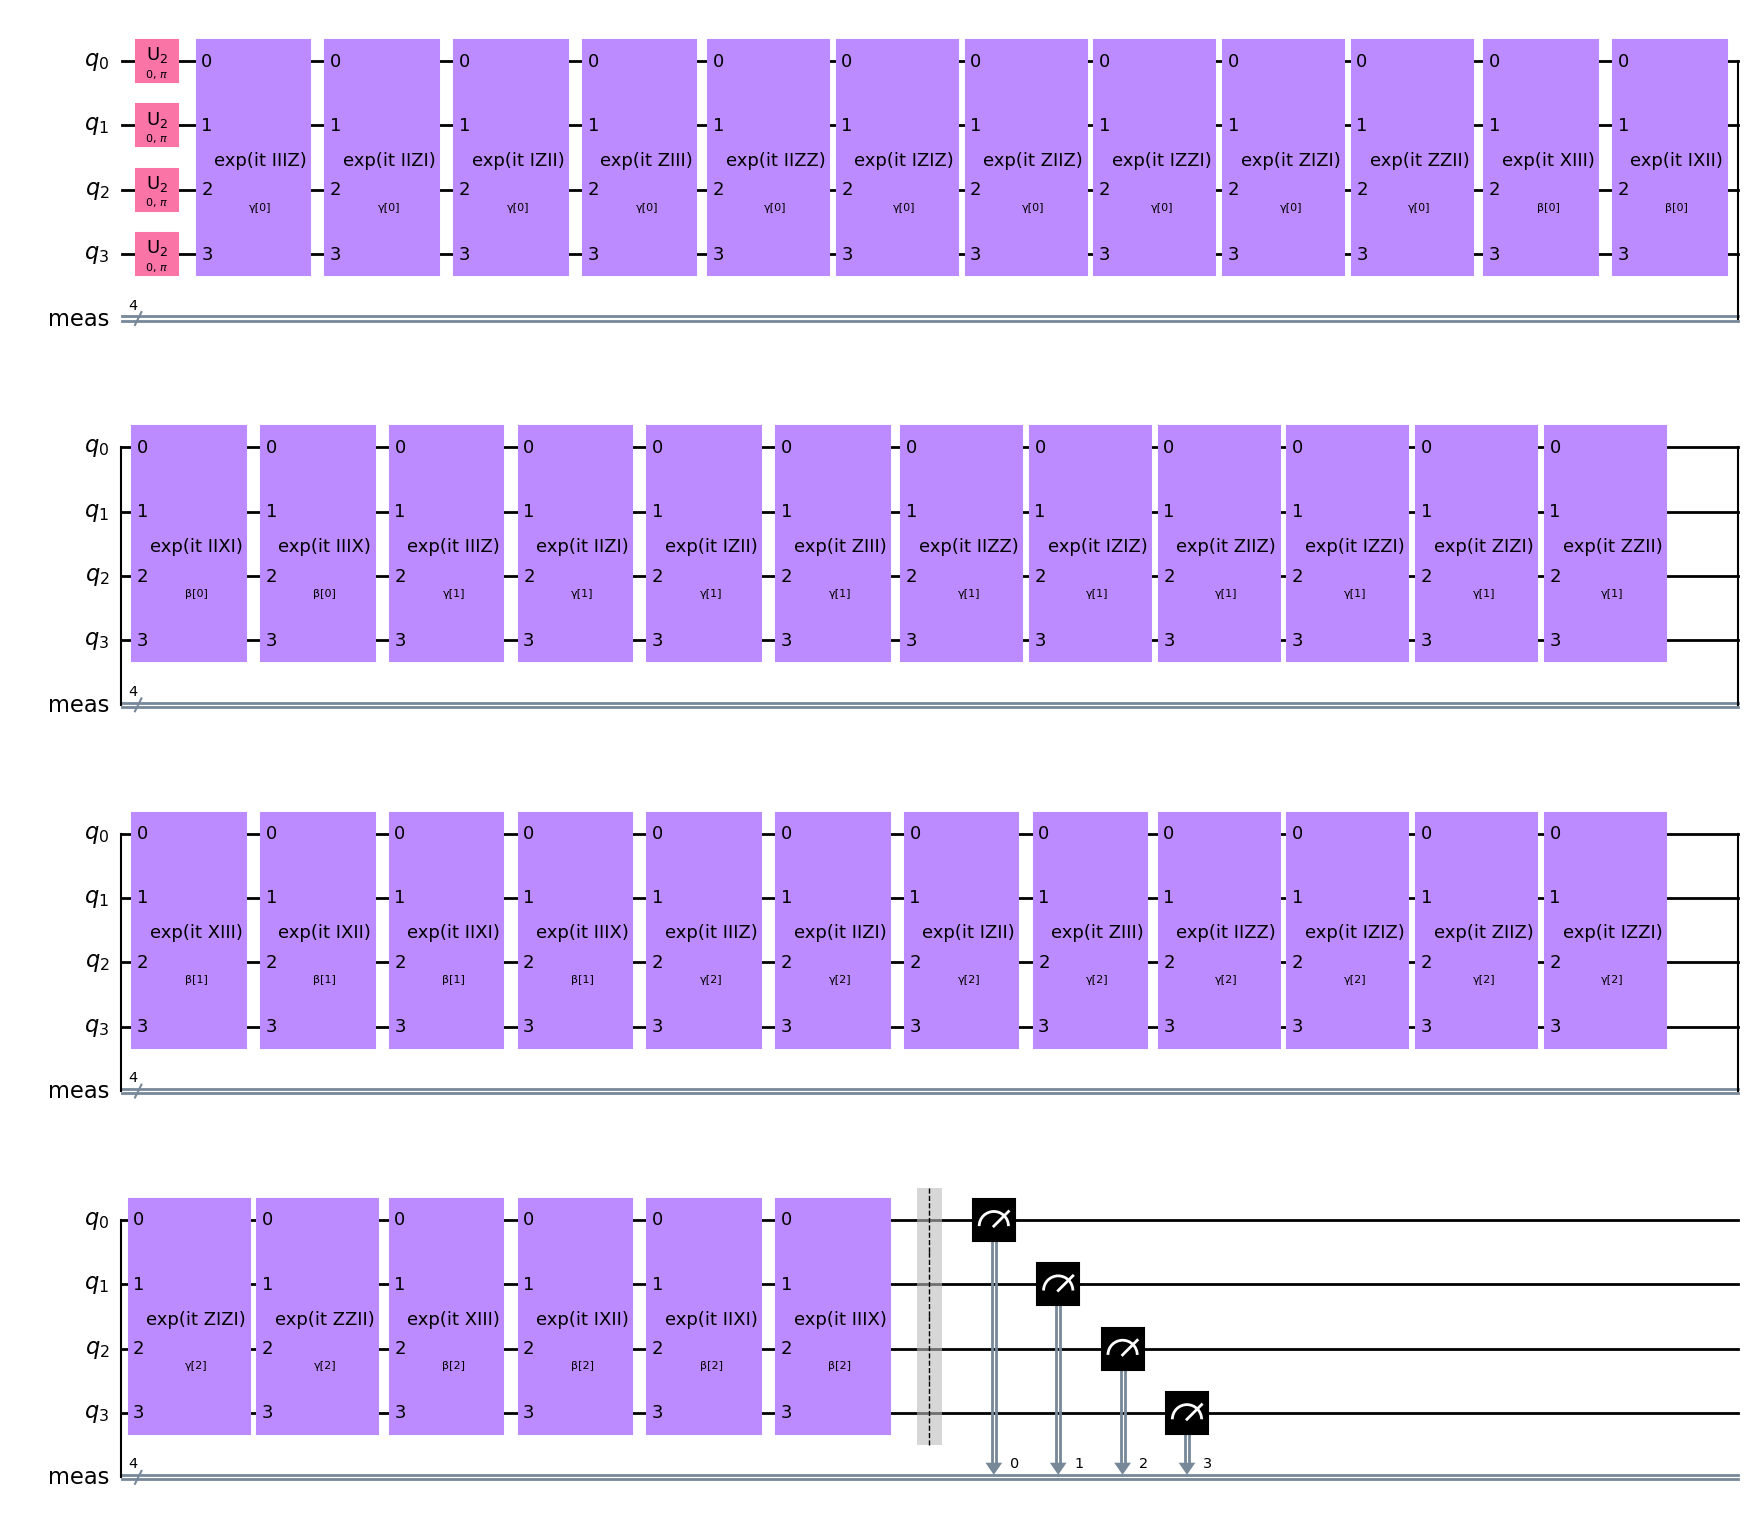

In [13]:
qaoa_mes.ansatz.decompose().draw("mpl")

### QAOA with GradientDescent Optimizer

In [18]:
from qiskit.algorithms.optimizers import  GradientDescent

result_g = MinimumEigenOptimizer(QAOA(Sampler(), GradientDescent(),reps=3)).solve(
    qp
)
print_result(result_g)

Optimal: selection [1. 0. 1. 0.], value -0.0022

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 1 0]	0.0009		0.1836
 [1 1 0 0]	0.0021		0.1729
 [0 1 0 1]	0.0030		0.1670
 [0 0 1 1]	-0.0013		0.1592
 [1 0 1 0]	-0.0022		0.1582
 [1 0 0 1]	-0.0001		0.1494
 [1 1 0 1]	0.0025		0.0039
 [0 0 0 1]	0.0004		0.0029
 [1 0 1 1]	-0.0018		0.0010
 [0 1 0 0]	0.0025		0.0010
 [0 0 0 0]	0.0000		0.0010


### Get time

In [14]:
import time
s = time.time()
for i in range(10):
    result = exact_eigensolver.solve(unconstraint_quadratic_problem)
e = time.time()
aver_time = (e-s)/10
print("NumPyMinimumEigensolver aver running time", aver_time ,"s")

NumPyMinimumEigensolver aver running time 0.03235528469085693 s


In [15]:
import time
s = time.time()
for i in range(10):
    result = vqe.solve(unconstraint_quadratic_problem)
e = time.time()
aver_time = (e-s)/10
print("vqe with COBYLA aver running time", aver_time ,"s")

vqe with COBYLA aver running time 1.4146004676818849 s


In [16]:
import time
s = time.time()
for i in range(10):
    result = qaoa.solve(unconstraint_quadratic_problem)
e = time.time()
aver_time = (e-s)/10
print("qaoa with COBYLA aver running time", aver_time ,"s")

qaoa with COBYLA aver running time 1.4639244318008422 s


In [19]:
qaoa_g = MinimumEigenOptimizer(QAOA(Sampler(), GradientDescent(),reps=3))
import time
s = time.time()
for i in range(10):
    result = qaoa_g.solve(unconstraint_quadratic_problem)
e = time.time()
aver_time = (e-s)/10
print("qaoa with GradientDescent aver running time", aver_time ,"s")

qaoa with GradientDescent aver running time 11.414355969429016 s


## TwoLocal+PSO

[TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#qiskit.circuit.library.TwoLocal)是一个参数化电路模板。

In [20]:
from qiskit import BasicAer, execute
from qiskit.circuit.library import TwoLocal
from sko.PSO import PSO

生成量子电路

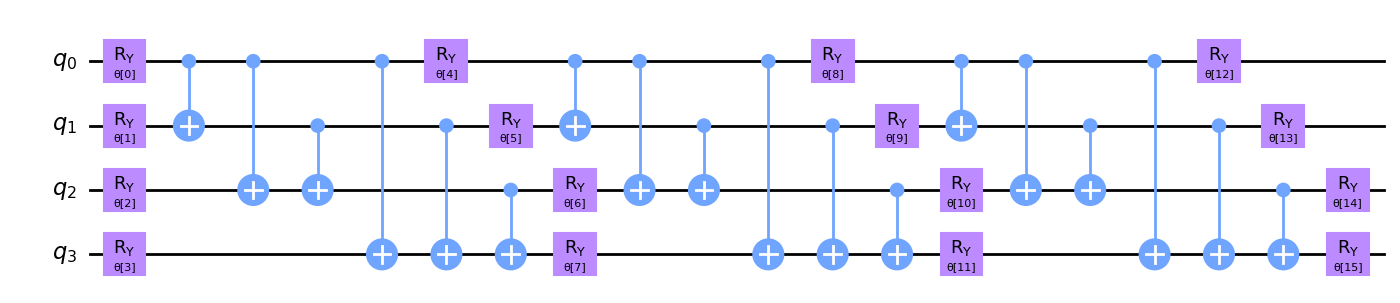

In [21]:
parameterized_qc = TwoLocal(4, "ry", "cx")
parameterized_qc.decompose().draw("mpl")

In [22]:
exact_qc = parameterized_qc.bind_parameters(
    list(range(parameterized_qc.num_parameters))
)

构建目标函数

In [23]:
def f(x1, x2, x3, x4):
    return qp.objective.evaluate([x1,x2,x3,x4])


def obj_func(params):
    exact_qc = parameterized_qc.bind_parameters(params)
    exact_qc.measure_all()
    counts = (
        execute(exact_qc, BasicAer.get_backend("qasm_simulator"), shots=1000)
        .result()
        .get_counts()
    )
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    # print("input [x1,x2,x3,x4] is: ",list(map(int, list(counts[0][0]))))
    return f(*list(map(int, list(counts[0][0]))))

def get_x(params):
    exact_qc = parameterized_qc.bind_parameters(params)
    exact_qc.measure_all()
    counts = (
        execute(exact_qc, BasicAer.get_backend("qasm_simulator"), shots=1000)
        .result()
        .get_counts()
    )
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    return list(map(int, list(counts[0][0])))

In [25]:

def run_pso(pso, iter, is_print):
    print("run pso to get iter\tgbest")
    for i in range(iter):
        pso.run(1)
        if is_print:
            print("best x is: ",f"{i+1}\t{get_x(pso.gbest_x)}")
            print("min object function value is: "f"{i+1}\t{pso.gbest_y}")

lb = [-np.pi]*parameterized_qc.num_parameters
ub = [np.pi]*parameterized_qc.num_parameters

pso = PSO(obj_func, parameterized_qc.num_parameters, pop=4, lb=lb, ub=ub)


run_pso(pso,10,is_print=True)

run pso to get iter	gbest
best x is:  1	[1, 0, 0, 1]
min object function value is: 1	[-0.00011729]
best x is:  2	[1, 0, 0, 1]
min object function value is: 2	[-0.00011729]
best x is:  3	[0, 0, 1, 0]
min object function value is: 3	[-0.00171637]
best x is:  4	[1, 0, 1, 0]
min object function value is: 4	[-0.00219702]
best x is:  5	[1, 0, 1, 0]
min object function value is: 5	[-0.00219702]
best x is:  6	[1, 0, 1, 0]
min object function value is: 6	[-0.00219702]
best x is:  7	[1, 0, 1, 0]
min object function value is: 7	[-0.00219702]
best x is:  8	[1, 0, 1, 0]
min object function value is: 8	[-0.00219702]
best x is:  9	[1, 0, 1, 0]
min object function value is: 9	[-0.00219702]
best x is:  10	[1, 0, 1, 0]
min object function value is: 10	[-0.00219702]


get time

In [26]:
import time
s = time.time()
for i in range(10):
    result = run_pso(pso,10,is_print=False)
e = time.time()
aver_time = (e-s)/10
print("pso aver running time", aver_time ,"s")

run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
run pso to get iter	gbest
pso aver running time 1.3228692531585693 s


## TwoLocal+DE

In [27]:
lb = [-np.pi]*parameterized_qc.num_parameters
ub = [np.pi]*parameterized_qc.num_parameters



#pso = PSO(obj_func, parameterized_qc.num_parameters, pop=4, lb=lb, ub=ub)
from sko.DE import DE

de = DE(obj_func, parameterized_qc.num_parameters, size_pop=4, lb=lb, ub=ub)


def run_de(de, iter, is_print):
    print("run de to get iter\tgbest")
    for i in range(iter):
        best_x, best_y = de.run(1)
        if is_print:
            print("best x is: ",f"{i+1}\t{get_x(best_x)}")
            print("min object function value is: "f"{i+1}\t{best_y}")
run_de(de, 10, True)

run de to get iter	gbest
best x is:  1	[1, 0, 1, 1]
min object function value is: 1	[-0.00183219]
best x is:  2	[1, 0, 1, 1]
min object function value is: 2	[0.00208871]
best x is:  3	[1, 0, 1, 0]
min object function value is: 3	[-0.00219702]
best x is:  4	[0, 0, 1, 0]
min object function value is: 4	[-0.00219702]
best x is:  5	[1, 0, 1, 0]
min object function value is: 5	[-0.00219702]
best x is:  6	[1, 0, 1, 0]
min object function value is: 6	[-0.00219702]
best x is:  7	[1, 0, 1, 0]
min object function value is: 7	[-0.00219702]
best x is:  8	[1, 0, 1, 0]
min object function value is: 8	[-0.00171637]
best x is:  9	[1, 0, 1, 0]
min object function value is: 9	[-0.00219702]
best x is:  10	[1, 0, 1, 0]
min object function value is: 10	[-0.00219702]


get time

In [28]:
import time
s = time.time()
for i in range(10):
    result = run_de(de,10,is_print=False)
e = time.time()
aver_time = (e-s)/10
print("de aver running time", aver_time ,"s")

run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
run de to get iter	gbest
de aver running time 3.1078768968582153 s
